In [4]:
import hashlib
import os
import random

from Crypto.Cipher import AES
from Crypto.Util.number import bytes_to_long, long_to_bytes
from Crypto.Util.Padding import pad, unpad
from tqdm import tqdm


def xor_bytestring(a, b):
    return bytes([i ^ j for i, j in zip(a, b)])


def xor_hexstring(a, b):
    res = b""
    x = bytes.fromhex(a)
    y = bytes.fromhex(b)
    for i, j in zip(x, y):
        res += bytes([i ^ j])
    return res


def xor_bytestring_rep(a, b):
    res = b""
    print(len(a), len(b))
    if len(a) > len(b):
        for i in range(0, len(a), len(b)):
            res += xor_bytestring(a[i : i + len(b)], b)
    else:
        for i in range(0, len(b), len(a)):
            res += xor_bytestring(b[i : i + len(a)], a)
    return res

# Prerequisites

- Block Ciphers pdf
- Stream ciphers pdfs
- No need to understand the inner workings of the block ciphers. We'll just understand them as black boxes

# Theory - Modes of operation

- [Computerphile video](https://www.youtube.com/watch?v=Rk0NIQfEXBA)
- [Professor Messer video](https://www.youtube.com/watch?v=6rE-KlhBlq4)


Let $(E, D)$ be a block cipher. Block ciphers encrypt only blocks of text so we need a way to chain them to encrypt a bigger file:
- Ex: AES128 enccrypts 128 bits of text so we need to chain them to encrypt / decrypt data
- Basically we are looking for ways to use block ciphers for encryption

Let 
- $E, D: \mathcal{K} \times \{0, 1\}^l \longrightarrow \{0, 1\}^l$ where $l$ is the number of bits
- $m, c \in \{0, 1\}^l$

For now we know 
- $c = E(k, m)$
- $m = D(k, m)$

We want to learn to do 
- Encryption: $(c_1, c_2, ... c_n) \longleftarrow MAGIC \longleftarrow (m_1, m_2, ... m_n)$
- Decryption:  $(m_1, m_2, ... m_n)\longleftarrow MAGIC \longleftarrow (c_1, c_2, ... c_n)$



**Deterministic encryption scheme - Definition**  
An encryption is *deterministic* if a particular plaintext is mapped to a fixed ciphertext if the key is unchanged

**Probabilistic encryption scheme - Definition**  
An encryption is *probabilistic* if it uses randomness to achieve a non-deterministic generation of the ciphertext

What are we analyzing at a mode of operation?
- How does it work?
- Security issues
- Implementation details (If encrypt/decrypt is paralellizable or not)

**One more note**
- In the coding part the messages need to be padded to fit the block size
- Padding attacks are a security issue for padding oracles

## ECB mode (Electronic Code Book Mode) 

### Theory

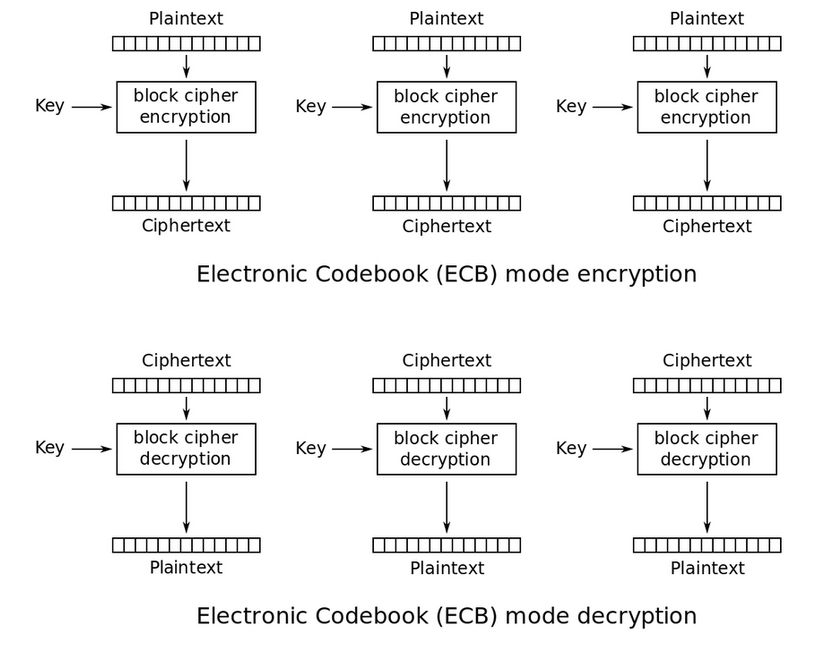
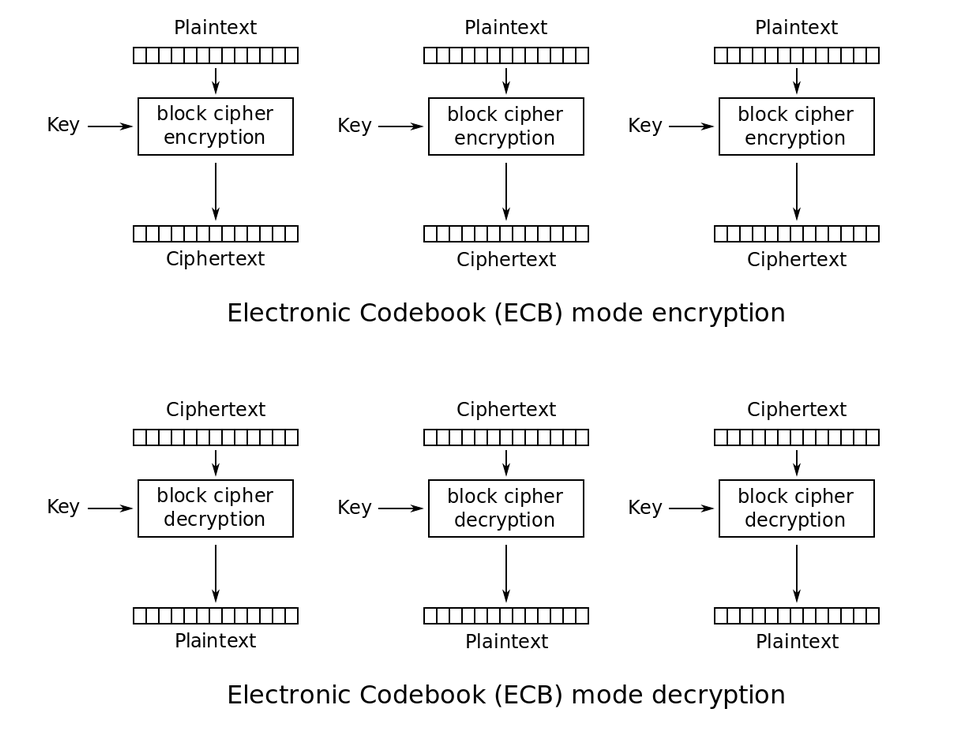

**How does it work?**
- Encryption 
    - $c_i = E(k, m_i) $
- Decryption
    - $m_i = D(k, c_i) $

**Parallelizable?**
- Encryption - YES
- Decryption - YES

**Security**
- Strengths
    - A single ECB block is secure
- Weaknesses
    - if $m_i = m_j => c_i = c_j$ 
        - Distinguishable from random
        - The same input generates the same output
    - Deterministic. The message encryption is the same every time
    - Weak to man in the middle by changing blocks
    - Data patterns can be found when encrypting large blocks of data
        - Ex: in images
    
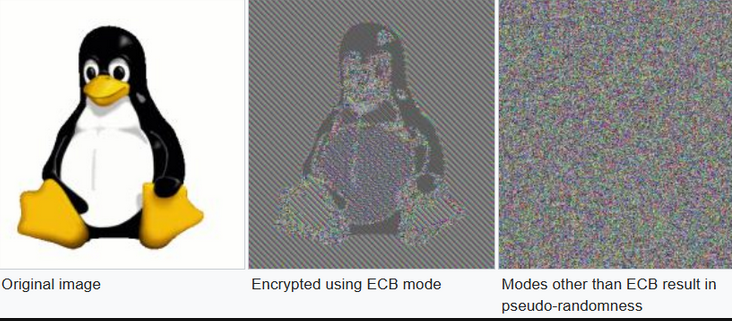
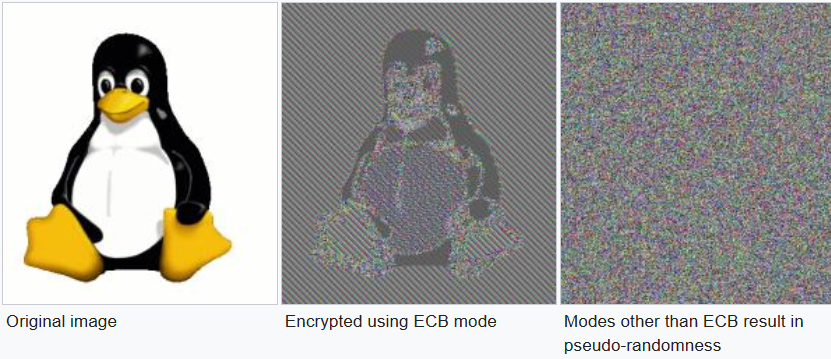

### Code

In [5]:
KEY = b"some secret key1"

In [6]:
m = b"a message secret longer than 128 bits"
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [7]:
pad(m, 16)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'

In [8]:
cipher = AES.new(KEY, AES.MODE_ECB)

c = cipher.encrypt(pad(m, 16))  # we pad the message
print(c)

m_decr = cipher.decrypt(c)
print(m_decr)

b'Ub,I\xc36\x07W\x1as\x03\x1d\x14\x99m_\x13\xd44\x1f\xd8\xa3\xb1\x9c\x87l&U\x93\x00\xac\xf7Y\x10wD.\xa2\xb9\x17L\x1a\xe3N\x1c\xf9\x8b_'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


In [9]:
# Weakness 1
m = b"a" * 16 + b"b" * 16 + b"a" * 16

cipher = AES.new(KEY, AES.MODE_ECB)

c = cipher.encrypt(m)  # we pad the message
print(c)
print("First 16 bytes == last 16 bytes? ", c[:16] == c[-16:])

m_decr = cipher.decrypt(c)
print(m_decr)

b"\xe6\x80\x05\x05\xc0~Pd/~\x1b\x0e\x04.\x07\xce\\K/'\x13\x0b6G\x16\xce%\xb8#\xf1\xa4b\xe6\x80\x05\x05\xc0~Pd/~\x1b\x0e\x04.\x07\xce"
First 16 bytes == last 16 bytes?  True
b'aaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaa'


## CBC Mode (Cipher block chaining)

### Theory

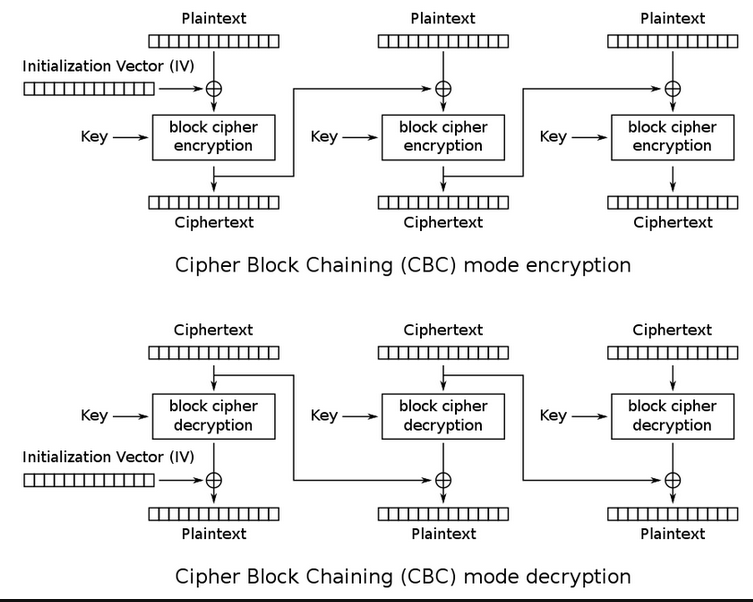
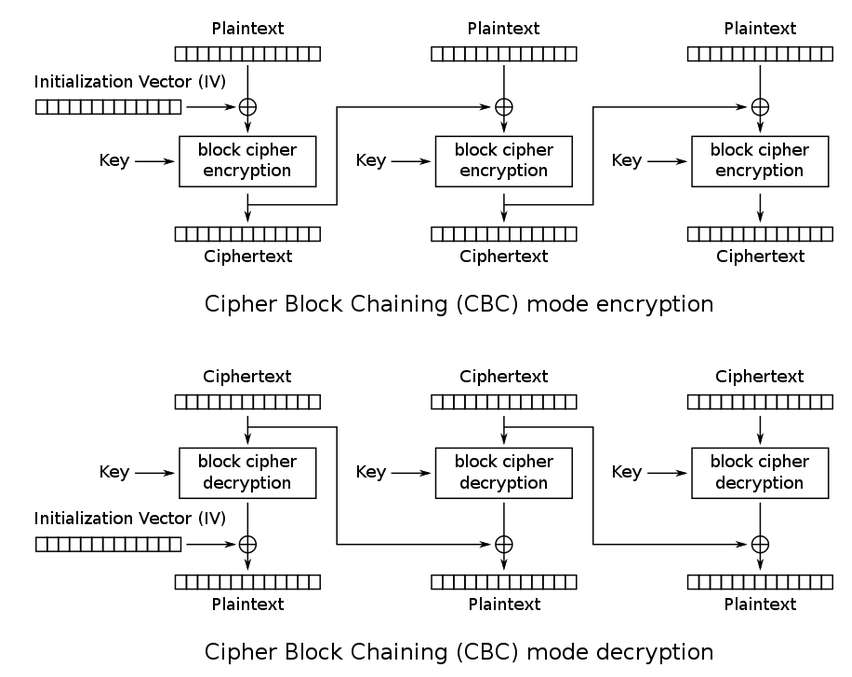

Solves ECB problems: 
- Makes encryption probabilistic (Uses an $IV$ = initialization vector)
- Combine encryption of all blocks

**How does it work?**
- Encryption 
    - $c_1 = E(k, m_1 \oplus IV)$
        - $IV$ = initialization vector
    - $c_i = E(k, m_i \oplus c_{i-1}) \text{ for } i > 1$
- Decryption
    - $m_1 = D(k, c_1) \oplus IV$
    - $m_i = D(k, c_i) \oplus c_{i-1}$

**Parallelizable?**
- Encryption - NO
- Decryption - YES

**Security**
- $IV$ security (Security depends on how the $IV$ is manipulated
    - If $IV$ is the same then we have deterministic encryption 
    - If $IV$ is used as a random nonce and it's sent with the ciphertext
        - Is not indistinguishable under a CPA
    - If $IV$ is completely random as an internal state
        - Secure under CPA

In [10]:
KEY = b"some secret key1"
IV = os.urandom(16)
IV

b"\xdb\xe8\xbc\x96\xb7,\xfaX\xe3\xca\xb1\xac'\xa4T\xdf"

In [11]:
m = b"a message secret longer than 128 bits"
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [12]:
pad(m, 16)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'

In [13]:
cipher = AES.new(KEY, AES.MODE_CBC, iv=IV)

c = cipher.encrypt(pad(m, 16))  # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_CBC, iv=IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'\xbc8\x99\xc0}O\xb9\xe2k&x\xf3\xe4,\xa0r\x02K\xda\xc2G\x94\xf5268z{\x92%\xee\\\x1c\x13\x8e\x9c\x9d\x1b\xe6%\x95\xa2\xb7!\xfeh\x89`'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


In [14]:
# ECB weakness isn't here anymore
m = b"a" * 16 + b"b" * 16 + b"a" * 16

cipher = AES.new(KEY, AES.MODE_CBC, iv=IV)

c = cipher.encrypt(m)  # we pad the message
print(c)
print("First 16 bytes == last 16 bytes? ", c[:16] == c[-16:])  # False

cipher = AES.new(KEY, AES.MODE_CBC, iv=IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'\xf7\xb2\x92{x\x88$\xac+\x08P6\x1a\x03X9\x97\xac,"\x17\xafn4yH\xe4\x065\x0e>\xda\xc2\x05\xd0\xb7\x05\\\xa0\xeb\xd2\xc7\xd0q\xe4o\xf9r'
First 16 bytes == last 16 bytes?  False
b'aaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaa'


## CFB (Cipher FeedBack)

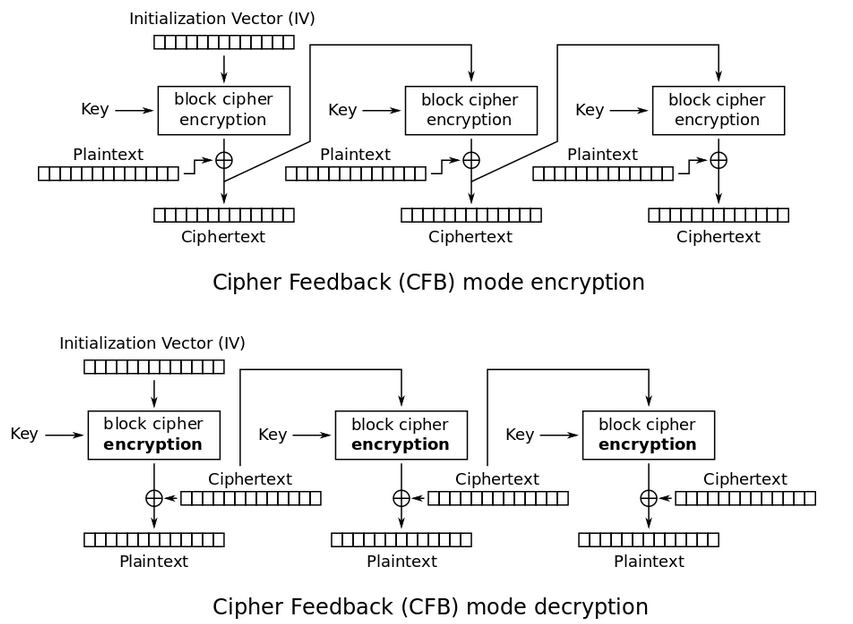
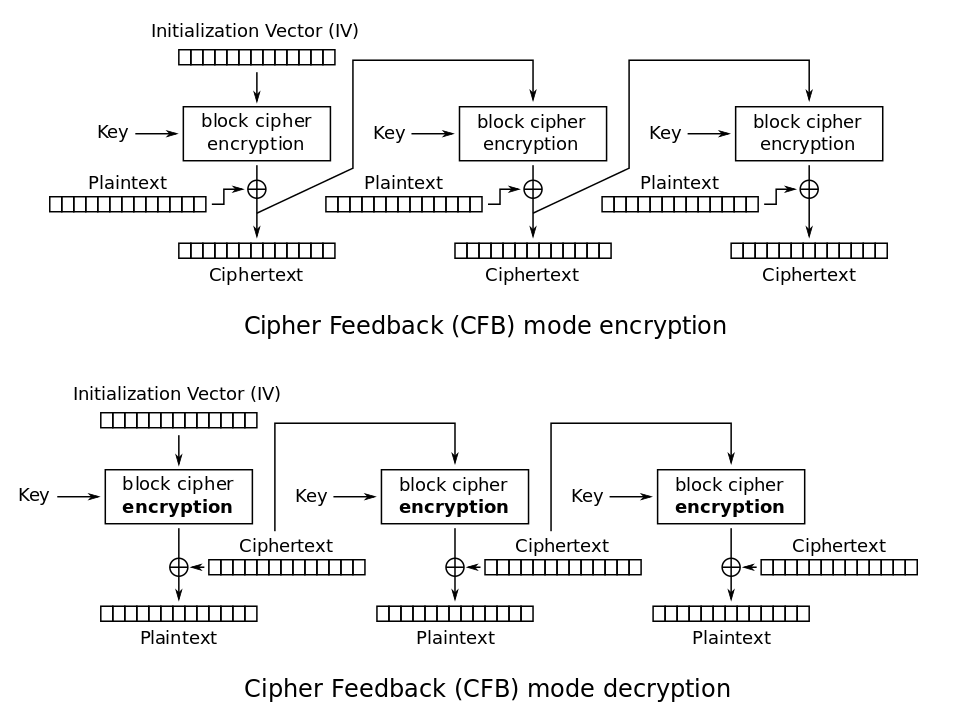

*Intuition*: uses the block cipher to produce a stream cipher

**How does it work?**
- Encryption 
    - $c_0 = IV$
    - $c_i = E(k, c_{i-1}) \oplus m_i \text{ for } i>=1$
    - The output is $IV || c_1 || c_2 ||...$
- Decryption
    - $m_i = E(k, c_{i-1}) \oplus c_i$
    

**Parallelizable?**
- Encryption - NO
- Decryption - YES

**Security**
- When $IV$ is used as a nonce then it is not indistinguishable from random under CPA
    - Attacker has $IV || c_1 || c_2 ||...$
    - Attacker queries $IV = c_1$ and $m_1 = 0$ => we will get $c' = E(k, c_1) \oplus 0$ 
    - We can decrypt $m_2 = E(k, c_{1}) \oplus c_2 = c' \oplus c_2$
    - We can get the messages after the first


In [15]:
m = b"a message secret longer than 128 bits"
print(len(m) * 8, len(m) * 8 > 128)

cipher = AES.new(KEY, AES.MODE_CFB, iv=IV)
c = cipher.encrypt(pad(m, 16))  # we pad the message
print(c)

296 True
b'W\x07\xbeMZ\xbc\x993\xaa\x1c8\x03\x0e\r\x16(\xb5\x89\xff\x1ff\xbc\xbdyHPO\xde)/J\x9fy\x82X\xea\xb7\x8f\xf7\xe1\xf6_\x05\x0eo\xdc\xd50'


In [16]:
cipher = AES.new(KEY, AES.MODE_CFB, iv=IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


#### The attack

In [17]:
KEY = b"some secret key1"
IV = os.urandom(16)
IV

b'\xfeE\xdcpp\xc8\x08\x03\xba\xa8\x85\x10\x1f\x00\x8a\x1c'

In [18]:
m = b"some trash inputSUPER SECRET STUFF HERE"
print(len(m))

cipher = AES.new(KEY, AES.MODE_CFB, iv=IV, segment_size=128)
c = cipher.encrypt(pad(m, 16))  # we pad the message
print(len(c), c)

39
48 b'\xf8\xdc`\x9cl\xfe\xf2A{uZ\xf0@\xe0N\x1f\x1e\xde\x06\xe6>CY\xcf\xb8\x13Mr%\n\xd9\x82\xb6r\xc0\xbdH2\x0b\xbbCsU\xce\xdf\x1e}\xe1'


In [19]:
cipher2 = AES.new(KEY, AES.MODE_CFB, iv=c[:16], segment_size=128)  # encryption oracle
c_ = cipher2.encrypt(bytes([0]) * 16)
c_

b'M\x8bV\xa3lc\n\x8a\xfbA\x08&\x05Y\x8d\xd7'

In [20]:
xor_bytestring(c_, c[16:32])

b'SUPER SECRET STU'

In [21]:
cipher2 = AES.new(KEY, AES.MODE_CFB, iv=c[16:32], segment_size=128)  # encryption oracle
c_ = cipher2.encrypt(bytes([0]) * 16)
c_
xor_bytestring(c_, c[32:48])

b'FF HERE\t\t\t\t\t\t\t\t\t'

## OFB mode (output feedback mode)

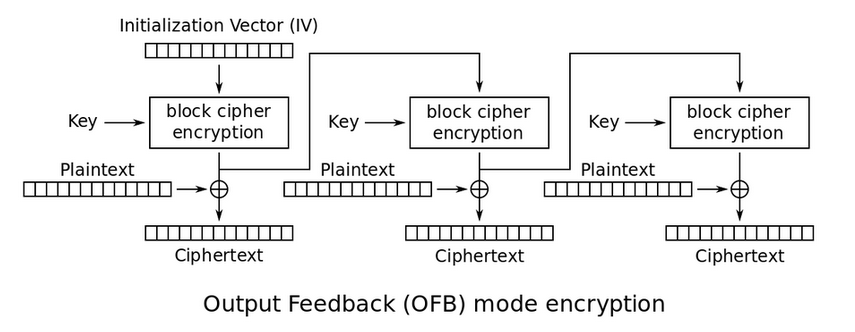
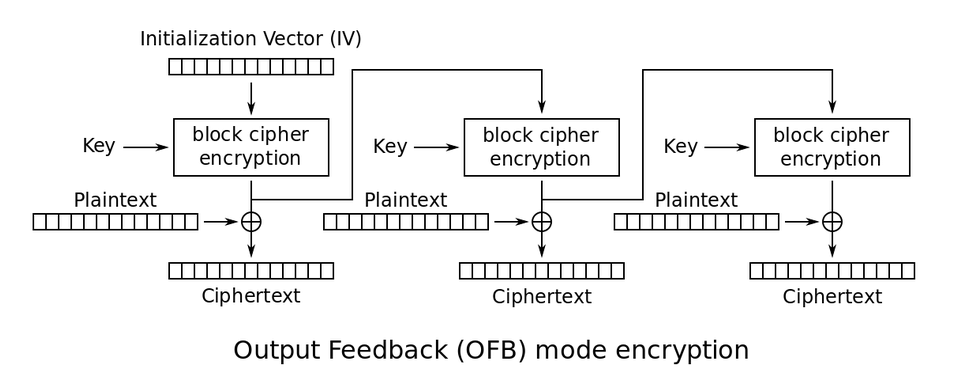

*Intuition*:
- Transforms a block cipher into a stream cipher -> We use the block cipher to create the keystream $y$
- It's symmetric => Encryption is the same as decryption

**How does it work?**
- Encryption 
    - $y_0 = IV$
    - $y_i = E(k, y_{i-1})$
    - $c_i = m_i \oplus y_i$
    - The output is $IV || c_1 || c_2 ||...$
- Decryption
    - Same as encryption, just reverse $m_i$ with $c_i$
    

**Parallelizable?**
- Encryption - NO
- Decryption - NO
- Note:
    - The key $y$ can be generated in advance

**Security**
- flipping a bit in the ciphertext changes the plaintext at the same location
- When used with a fixed $IV$ OFB is not indistinguishable from random under a CPA

In [22]:
KEY = b"some secret key1"
IV = os.urandom(16)

In [23]:
m = b"a message secret longer than 128 bits"
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [24]:
cipher = AES.new(KEY, AES.MODE_OFB, iv=IV)

c = cipher.encrypt(pad(m, 16))  # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_OFB, iv=IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'\x92\xfaU\xa3\xa7`\xecjM<\xe3\xeek\x11\x84|\xc8\r~\x02\x7f\x81\xdb\x04\x84\xe3L\x8b\xf1.,\xd2\x9b\x8c\x8e\xdcn7\xaa\xbd\x0c\x1b\x15\x1a\xc4\x91BR'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


## CTR (Counter mode)

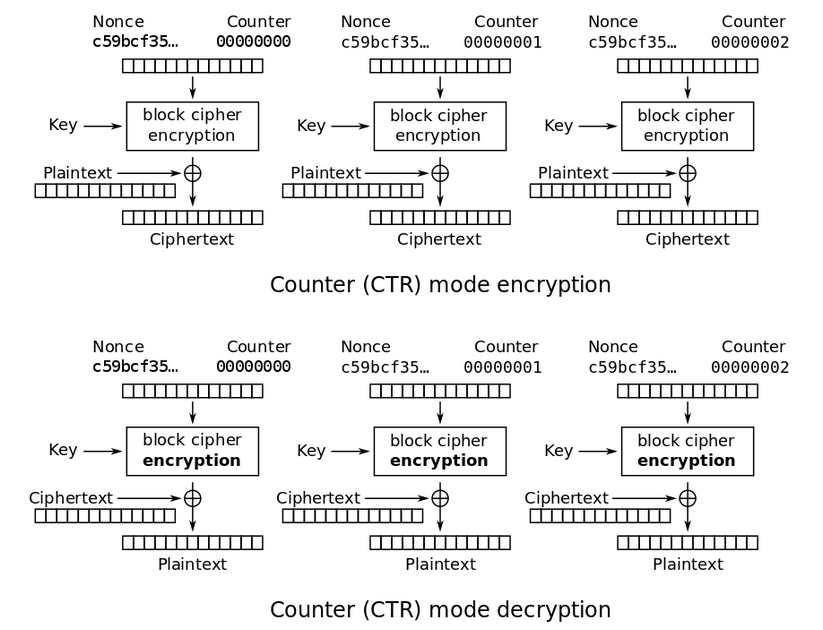
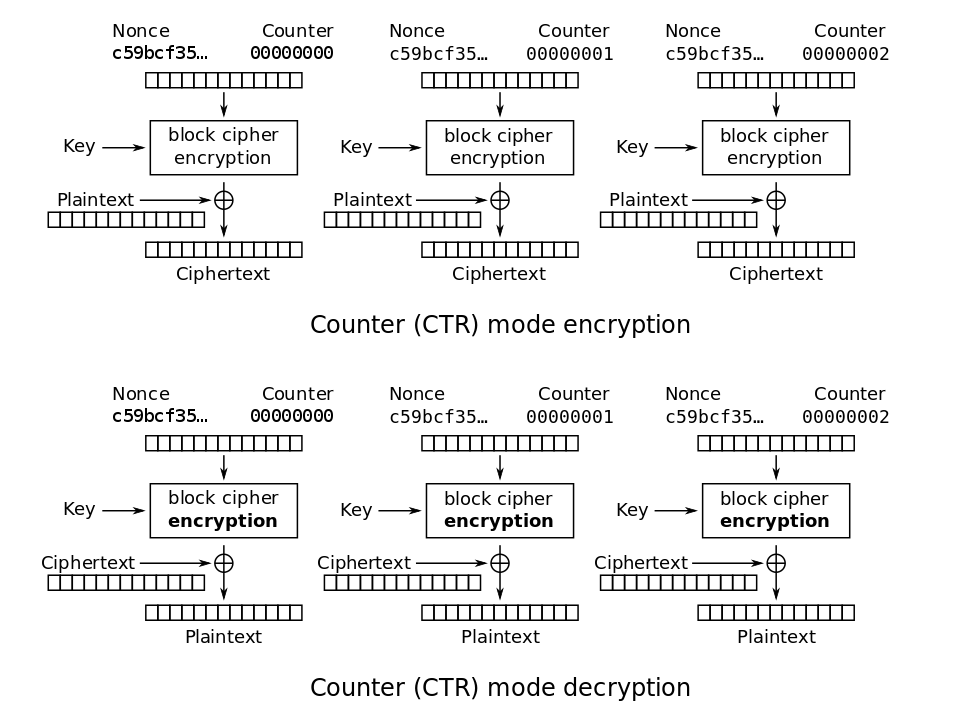

*Intuition*:
- Transforms the block cipher into a stream cipher
- Uses the block cipher on a counter to generate a keystream

**How does it work?**
- Encryption 
    - $c_i = m_i \oplus E(k, IV + i)$
- Decryption
    - $m_i = c_i \oplus E(k, IV + i)$
    
**Parallelizable?**
- Encryption - YES
- Decryption - YES
- Note:
    - The key $y$ can be generated in advance

**Security**
- Is indistinguishable from random  under CPA

In [25]:
from Crypto.Util import Counter

KEY = b"some secret key1"
IV = os.urandom(16)

In [26]:
m = b"a message secret longer than 128 bits"
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [27]:
cipher = AES.new(KEY, AES.MODE_CTR, counter=Counter.new(128, initial_value=bytes_to_long(IV)))
c = cipher.encrypt(pad(m, 16))  # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_CTR, counter=Counter.new(128, initial_value=bytes_to_long(IV)))
m_decr = cipher.decrypt(c)
print(m_decr)

b'\xe36\x8b7#;\xa4C\x92z\xb4\xe0\x1aO\xc2O\xe3\xee\x01\xaf\x14gF\xbe\xbfO\x02\xd6\xd2\xf7\xdc<rA\xc5 \x84w\x1d\xe4J\x86r\x059\xcf\x93\xc0'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


 # Resources

- [computerphile video](https://www.youtube.com/watch?v=Rk0NIQfEXBA)
- [Geek For Geeks](https://www.geeksforgeeks.org/block-cipher-modes-of-operation/)
- http://www.crypto-it.net/eng/theory/modes-of-block-ciphers.html
- https://www.highgo.ca/2019/08/08/the-difference-in-five-modes-in-the-aes-encryption-algorithm/